## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the Dataset

In [2]:
import os
import tarfile

### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.

In [3]:
def transform_pubmed(inFeat, outFeat, inNet, outNet):
    with open(inFeat) as f:
        with open(outFeat, 'w') as out:
            ignore = True
            head = True
            target = {}
            features = {}
            for line in f:
                if ignore:
                    ignore = False
                    continue
                if head:
                    head = False
                    s = line.split()[1:-1]
                    s = [x.split(':')[1] for x in s]
                    feats_nums = {s[i]: i for i in range(len(s))}
                    continue
                s = line.split()
                id = s[0]
                target[id] = s[1].split('=')[1]
                assert (s[1].split('=')[0] == 'label')
                idx = [feats_nums[x.split('=')[0]] for x in s[2:-1]]
                feats = [1 if i in idx else 0 for i in range(len(feats_nums))]
                features[id] = feats
                out.write(id + ' ')
                out.write(' '.join([str(x) for x in feats]))
                out.write(' ' + target[id] + '\n')
    with open(inNet) as f:
        with open(outNet, 'w') as out:
            ignore = True
            head = True
            for line in f:
                if ignore:
                    ignore = False
                    continue
                if head:
                    head = False
                    continue
                s = line.split()
                u = s[1].split(':')[1]
                v = s[3].split(':')[1]
                out.write(v + ' ' + u + '\n')
                


In [4]:
import os

# Dataset and paths
dataset_name = 'pubmed'
input_dir = '/kaggle/input/pumbed1'  # Read-only input directory in Kaggle
output_dir = '/kaggle/working/data/graphs/processed'  # Writable directory for processed data

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# File paths
node_file = os.path.join(input_dir, 'Pubmed-Diabetes.NODE.paper.tab')  # Input node file
content_file = os.path.join(output_dir, f'{dataset_name}.content')  # Output content file
cites_file = os.path.join(input_dir, 'Pubmed-Diabetes.DIRECTED.cites.tab')  # Input cites file
cites_output_file = os.path.join(output_dir, f'{dataset_name}.cites')  # Output cites file

# Call transform_pubmed with updated paths
transform_pubmed(node_file, content_file, cites_file, cites_output_file)
data_dir = f'/kaggle/working/data/graphs/processed'
print(f"Processed files saved in {output_dir}")


Processed files saved in /kaggle/working/data/graphs/processed


In [5]:
print(node_file)

# Class 0: Diabetes Type 1
# Class 1: Diabetes Type 2
# Class 2: Experimental research on diabetes (other diabetes-related studies)

/kaggle/input/pumbed1/Pubmed-Diabetes.NODE.paper.tab


In [6]:
citations = pd.read_csv(
    os.path.join(data_dir, "pubmed.cites"),
    sep=" ", 
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (44338, 2)


Now we display a sample of the `citations` DataFrame.
The `target` column includes the paper ids cited by the paper ids in the `source` column.

In [7]:
citations.sample(frac=1).head()

,target,source
14206,9851666,15270841
44128,7698052,16215165
6429,16249540,18258851
11805,9285498,18555826
12928,4581053,8200993


Now let's load the papers data into a Pandas DataFrame.

In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(500)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "pubmed.content"), sep=" ", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (19717, 502)


In [9]:
print(papers["subject"])

0        1
1        1
2        1
3        2
4        1
        ..
19712    3
19713    2
19714    1
19715    3
19716    3
Name: subject, Length: 19717, dtype: int64


In [10]:
print(papers.head())

   paper_id  term_0  term_1  term_2  term_3  term_4  term_5  term_6  term_7  \
0  12187484       1       1       1       1       1       1       1       1   
1   2344352       1       0       1       0       0       0       0       0   
2  14654069       1       0       1       0       0       0       0       0   
3  16443886       0       0       0       0       0       0       0       0   
4   2684155       1       0       0       0       0       0       0       0   

   term_8  ...  term_491  term_492  term_493  term_494  term_495  term_496  \
0       1  ...         0         0         0         0         0         0   
1       1  ...         0         0         0         0         0         0   
2       1  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       1  ...         0         0         0         0         0         0   

   term_497  term_498  term_499  subject  
0         0  

Now we display a sample of the `papers` DataFrame. The DataFrame includes the `paper_id`
and the `subject` columns, as well as 1,433 binary column representing whether a term exists
in the paper or not.

In [11]:
print(papers.sample(5).T)

             15111     16829     8478      15789     6495 
paper_id  17379048  15369805  15284064  15914522  10088625
term_0           0         0         1         0         0
term_1           0         0         0         0         0
term_2           0         1         0         0         1
term_3           0         0         0         0         1
...            ...       ...       ...       ...       ...
term_496         0         0         0         0         0
term_497         0         0         0         0         0
term_498         0         0         0         0         0
term_499         0         0         0         0         0
subject          3         3         1         2         3

[502 rows x 5 columns]


Let's display the count of the papers in each subject.

In [12]:
print(papers.subject.value_counts())

subject
2    7875
3    7739
1    4103
Name: count, dtype: int64


We convert the paper ids and the subjects into zero-based indices.

In [13]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Now let's visualize the citation graph. Each node in the graph represents a paper,
and the color of the node corresponds to its subject. Note that we only show a sample of
the papers in the dataset.

# **VIS1**

In [14]:

# #A more visually appealing Graph #Megha
# import matplotlib.pyplot as plt
# import networkx as nx
# import seaborn as sns

# # Increase the figure size to accommodate the larger graph
# plt.figure(figsize=(15, 15))

# # Create the graph from a sample of the citations
# cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))

# # Get the subjects for the sampled nodes
# subjects = papers[papers["paper_id"].isin(cora_graph.nodes())]["subject"]

# # Create a color palette based on unique subjects
# unique_subjects = list(papers["subject"].unique())
# palette = sns.color_palette("husl", len(unique_subjects))  # Seaborn color palette
# color_map = dict(zip(unique_subjects, palette))  # Map subjects to colors
# node_colors = [color_map[subj] for subj in subjects]

# # Calculate node degrees to scale node sizes (optional)
# degrees = dict(nx.degree(cora_graph))
# node_sizes = [degrees[node] * 5 for node in cora_graph.nodes()]  # Adjust size scale

# # Plot the graph using a spring layout
# pos = nx.spring_layout(cora_graph, k=0.1, iterations=50)  # k and iterations adjusted for larger graphs
# nx.draw_networkx_edges(cora_graph, pos, alpha=0.1)  # Add transparency to edges
# nx.draw_networkx_nodes(cora_graph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis)

# # Add a legend for the subject categories
# for subject, color in color_map.items():
#     plt.scatter([], [], c=[color], label=subject)
# plt.legend(scatterpoints=1, frameon=False, title="Subjects", loc="best", fontsize=12)

# # Hide axis for a cleaner look
# plt.axis('off')

# plt.show()

In [15]:
# degrees = [cora_graph.degree(n) for n in cora_graph.nodes]
# plt.hist(degrees, bins=10)
# plt.title("Degree Distribution")
# plt.xlabel("Degree")
# plt.ylabel("Frequency")
# plt.show()

In [16]:
# centrality = nx.degree_centrality(cora_graph)
# centrality_values = list(centrality.values())

# plt.hist(centrality_values, bins=50)
# plt.title("Degree Centrality Distribution")
# plt.xlabel("Centrality")
# plt.ylabel("Frequency")
# plt.show()


# **VIS2**

In [17]:
# plt.figure(figsize=(8, 6))
# papers['subject'].value_counts().plot(kind='bar', color='skyblue')
# plt.title("Class Distribution of Papers")
# plt.xlabel("Subject")
# plt.ylabel("Count")
# plt.show()

In [18]:
# ## Visualize the local clustering coefficient, which measures how close a node’s 
# ## neighbors are to forming a complete graph (i.e., how interconnected they are).

# clustering_coeffs = nx.clustering(cora_graph)
# plt.hist(clustering_coeffs.values(), bins=10)
# plt.title("Clustering Coefficient Distribution")
# plt.xlabel("Clustering Coefficient")
# plt.ylabel("Frequency")
# plt.show()


# **VIS3**

In [19]:
# ## Plot the distribution of the shortest path lengths between nodes, which can reveal how interconnected the graph is.
# path_lengths = dict(nx.shortest_path_length(cora_graph))
# all_lengths = [length for source in path_lengths for length in path_lengths[source].values()]

# plt.hist(all_lengths, bins=100)
# plt.title("Shortest Path Length Distribution")
# plt.xlabel("Path Length")
# plt.ylabel("Frequency")
# plt.show()

In [20]:
# density = nx.density(cora_graph)
# print(f"Graph Density: {density:.4f}")

In [21]:

# papers['subject'].map(subject_mapping)
# papers['subject']
# papers['subject_numeric']

# **VIS4**

In [22]:
# from sklearn.manifold import TSNE

# # Assuming 'features' is the node feature matrix from the earlier processing
# tsne = TSNE(n_components=2, random_state=42)
# node_embeddings_2d = tsne.fit_transform(papers.iloc[:, 1:-1].values)

# subject_mapping = {subject: idx for idx, subject in enumerate(class_values)}
# papers['subject_numeric'] = papers['subject'].map(subject_mapping)
# papers['subject_numeric'] = papers['subject_numeric'].fillna(2.0)

# plt.figure(figsize=(8, 6))
# plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=papers['subject_numeric'], cmap='jet', s=10)
# plt.title("t-SNE Node Embeddings")
# plt.colorbar(ticks=range(len(class_values)), label='Subject')
# plt.clim(-0.5, len(class_values) - 0.5)  # Adjust color limits to match subject range
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.show()

In [23]:
# plt.figure(figsize=(10, 10))
# plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=papers['subject_numeric'], cmap='jet', s=10)
# plt.title("Node Embeddings Colored by Subject")
# plt.colorbar(ticks=range(len(class_values)), label='Subject')
# plt.clim(-0.5, len(class_values) - 0.5)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.show()

In [24]:
# subject_degrees = pd.DataFrame({
#     'degree': [cora_graph.degree(node) for node in cora_graph.nodes()],
#     'subject': [
#         papers.loc[papers['paper_id'] == node, 'subject'].values[0] if not papers.loc[papers['paper_id'] == node, 'subject'].empty else None
#         for node in cora_graph.nodes()
#     ]
# })

# plt.figure(figsize=(12, 6))
# sns.boxplot(x='subject', y='degree', data=subject_degrees)
# plt.title("Node Degree Distribution by Subject")
# plt.xticks(rotation=45)
# plt.show()

# **VIS5**

In [25]:
# import seaborn as sns
# import pandas as pd

# # Create a DataFrame for the embeddings
# embedding_df = pd.DataFrame(node_embeddings_2d, columns=['Dim1', 'Dim2'])
# embedding_df['subject'] = papers['subject'].map(subject_mapping)
# embedding_df['subject'] = embedding_df['subject'].fillna(2.0)

# sns.pairplot(embedding_df, hue='subject', palette='viridis')
# plt.suptitle("Pair Plot of Node Embeddings", y=1.02)
# plt.show()

### Split the dataset into stratified train and test sets

In [26]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (9810, 502)
Test data shape: (9907, 502)


## Implement Train and Evaluate Experiment

In [27]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 40
batch_size = 256

This function compiles and trains an input model using the given training data.

In [28]:

def run_experiment(model, x_train, y_train):
    #Compile the model.
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


This function displays the loss and accuracy curves of the model during training.

In [29]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


## Implement Feedforward Network (FFN) Module

We will use this module in the baseline and the GNN models.

In [30]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


## Build a Baseline Neural Network Model

### Prepare the data for the baseline model

In [31]:
# Convert the set to a list for indexing
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

# Create train and test targets as a numpy array.
y_train = train_data["subject"].to_numpy()
y_test = test_data["subject"].to_numpy()

In [32]:
# Define feature names as a list instead of a set
feature_names = list(set(papers.columns) - {"paper_id", "subject"})  # Convert set to list
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

# Create train and test targets as a numpy array
y_train = train_data["subject"].to_numpy()  # Convert targets to numpy array
y_test = test_data["subject"].to_numpy()    # Convert targets to numpy array

### Implement a baseline classifier

We add five FFN blocks with skip connections, so that we generate a baseline model with
roughly the same number of parameters as the GNN models to be built later.

In [33]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.5):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │     19,216 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 3)         │         99 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,787 (112.45 KB)

 Trainable params: 27,211 (106.29 KB)

 Non-trainable params: 1,576 (6.16 KB)

### Train the baseline classifier

In [34]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - acc: 0.2984 - loss: 2.9115 - val_acc: 0.3940 - val_loss: 1.0889
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.3678 - loss: 1.5695 - val_acc: 0.4144 - val_loss: 1.0801
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3862 - loss: 1.3783 - val_acc: 0.4124 - val_loss: 1.0752
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.3999 - loss: 1.2550 - val_acc: 0.4178 - val_loss: 1.0659
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.4252 - loss: 1.1788 - val_acc: 0.4185 - val_loss: 1.0576
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4173 - loss: 1.1553 - val_acc: 0.4239 - val_loss: 1.0498
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4157 - loss: 1.1159 - val_acc: 0.4633 - val_loss: 1.0438
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4242 - loss: 1.0959 - val_acc: 0.4620 - val_loss: 1.0360
Epoch 9/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4416

Let's plot the learning curves.

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_proba = baseline_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Calculate metrics (assuming y_test contains true class indices)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7051
Precision: 0.7367
Recall: 0.7051
F1 Score: 0.6981


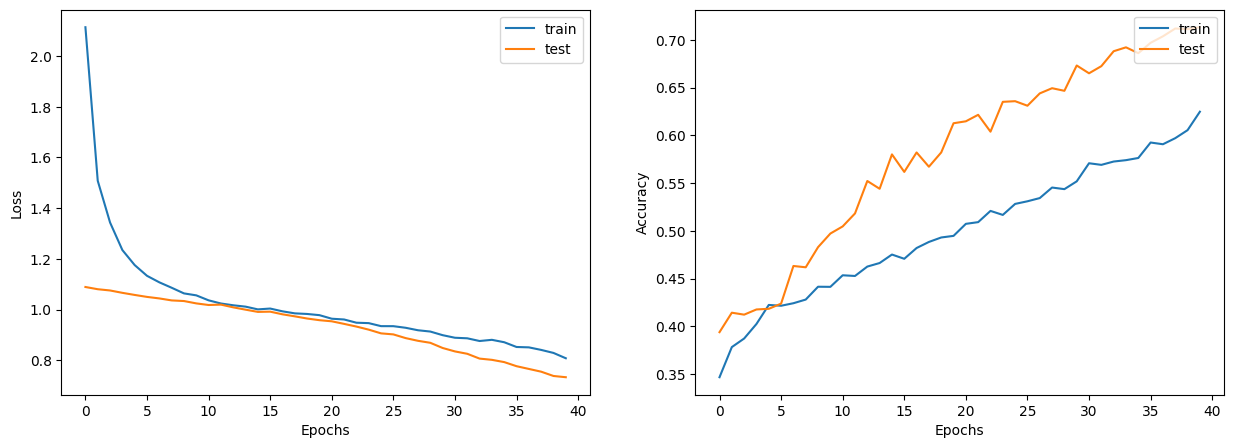

In [36]:
display_learning_curves(history)

In [37]:
# Predict probabilities for each class
y_pred_proba_baseline = baseline_model.predict(x_test)
# Predict classes
y_pred_baseline = np.argmax(y_pred_proba_baseline, axis=1)

# # Compute ROC curve and ROC area for each class
# fpr_baseline = dict()
# tpr_baseline = dict()
# roc_auc_baseline = dict()
# for i in range(num_classes):
#     fpr_baseline[i], tpr_baseline[i], _ = roc_curve(y_test == i, y_pred_proba_baseline[:, i])
#     roc_auc_baseline[i] = auc(fpr_baseline[i], tpr_baseline[i])

# # Plot ROC curve
# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(fpr_baseline[i], tpr_baseline[i], label=f'ROC curve (area = {roc_auc_baseline[i]:0.2f}) for {class_values[i]}')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) for Baseline Model')
# plt.legend(loc="lower right")
# plt.show()

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


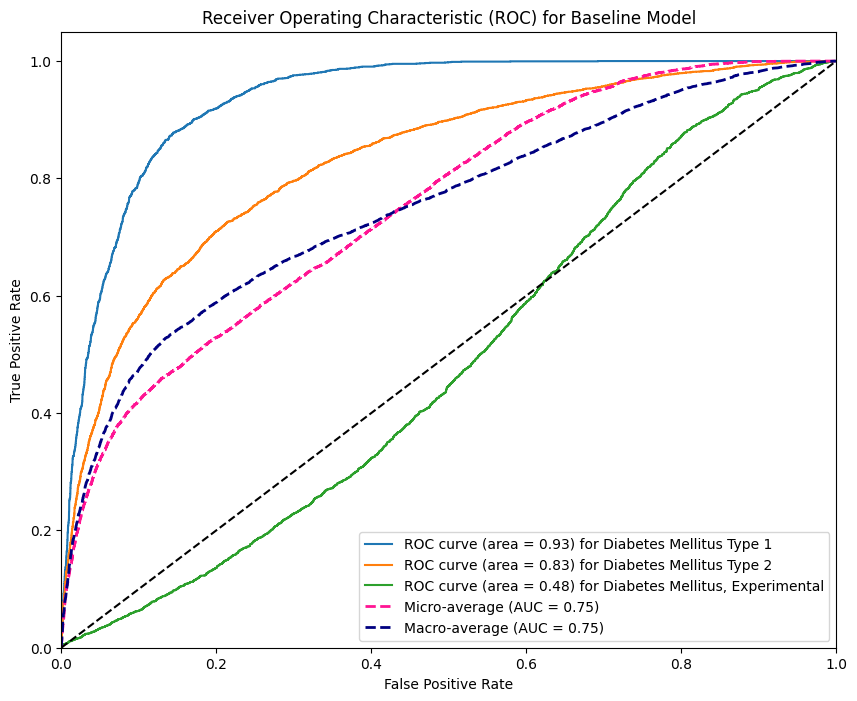

In [38]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities for each class
y_pred_proba_baseline = baseline_model.predict(x_test)
# Predict classes
y_pred_baseline = np.argmax(y_pred_proba_baseline, axis=1)

# Number of classes
num_classes = 3

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr_baseline = dict()
tpr_baseline = dict()
roc_auc_baseline = dict()
class_names = ['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental']

for i in range(num_classes):
    fpr_baseline[i], tpr_baseline[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_baseline[:, i])
    roc_auc_baseline[i] = auc(fpr_baseline[i], tpr_baseline[i])

# Compute micro-average ROC curve and ROC area
fpr_baseline["micro"], tpr_baseline["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_baseline.ravel())
roc_auc_baseline["micro"] = auc(fpr_baseline["micro"], tpr_baseline["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr_baseline[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr_baseline[i], tpr_baseline[i])
mean_tpr /= num_classes

fpr_baseline["macro"] = all_fpr
tpr_baseline["macro"] = mean_tpr
roc_auc_baseline["macro"] = auc(fpr_baseline["macro"], tpr_baseline["macro"])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr_baseline[i], tpr_baseline[i], label=f'ROC curve (area = {roc_auc_baseline[i]:0.2f}) for {class_names[i]}')

plt.plot(fpr_baseline["micro"], tpr_baseline["micro"], linestyle='--', color='deeppink', lw=2,
         label=f"Micro-average (AUC = {roc_auc_baseline['micro']:.2f})")

plt.plot(fpr_baseline["macro"], tpr_baseline["macro"], linestyle='--', color='navy', lw=2,
         label=f"Macro-average (AUC = {roc_auc_baseline['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Baseline Model')
plt.legend(loc="lower right")
plt.show()


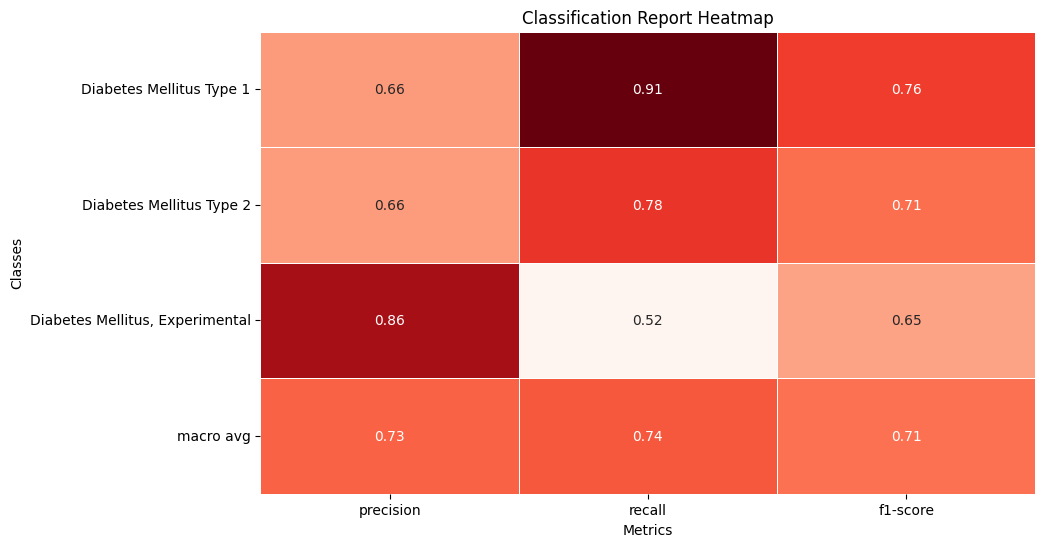

In [39]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_baseline are your true and predicted labels
# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred_baseline, target_names=[
    'Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental'], output_dict=True)

# Convert the dictionary into a Pandas DataFrame for visualization
report_df = pd.DataFrame(report_dict).transpose()

# Drop accuracy row if not needed for heatmap
if "accuracy" in report_df.index:
    report_df = report_df.drop("accuracy", axis=0)

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Reds", fmt=".2f", cbar=False, linewidths=0.5)

# Add labels and title
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


In [40]:
# from sklearn.metrics import classification_report
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming y_true_classes and y_pred_classes are your true and predicted labels
# # Generate classification report as a dictionary
# report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# # Convert the dictionary into a Pandas DataFrame for visualization
# report_df = pd.DataFrame(report_dict).transpose()

# # Map numeric indices to descriptive class names
# class_names = ['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental']
# report_df.index = [class_names[int(i)] if i.isdigit() else i for i in report_df.index]

# # Extract only relevant columns for better readability
# if "accuracy" in report_df.index:  # accuracy row is not relevant for heatmap
#     report_df = report_df.drop("accuracy", axis=0)

# # Plot the classification report as a heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Reds", fmt=".2f", cbar=False, linewidths=0.5)

# # Add labels and title
# plt.title("Classification Report Heatmap")
# plt.xlabel("Metrics")
# plt.ylabel("Classes")
# plt.show()

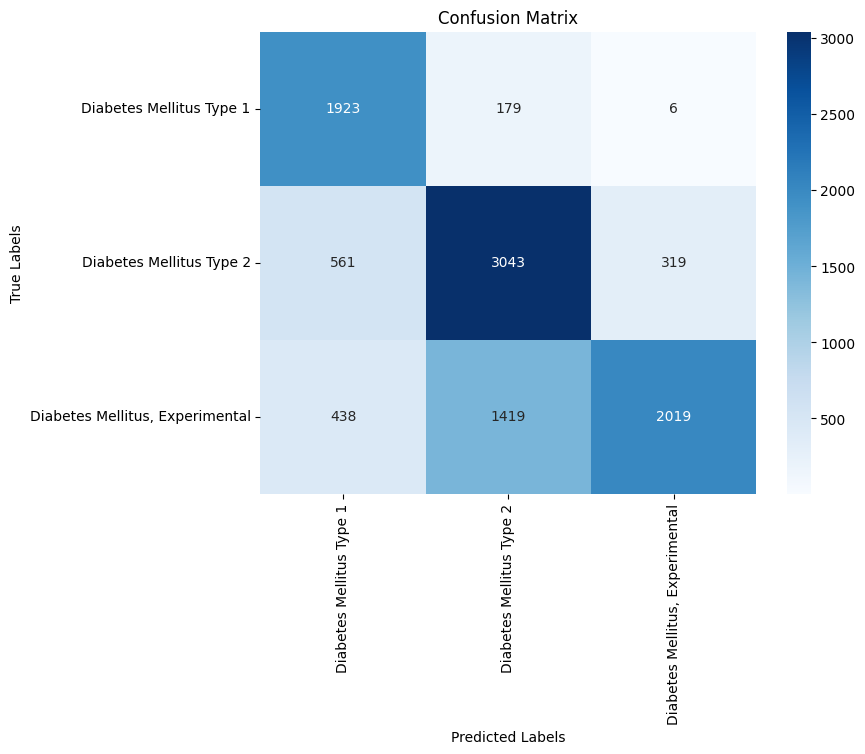

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_baseline are your true and predicted labels
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_baseline)

# Define class names
class_names = ['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [42]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Define descriptive class names
# class_names = ["Diabetes Mellitus Type 1", "Diabetes Mellitus Type 2", "Diabetes Mellitus, Experimental"]

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# # Plot confusion matrix with descriptive labels
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

# # Print classification report with descriptive labels
# print("\nClassification Report:")
# print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Now we evaluate the baseline model on the test data split.

In [43]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
_, train_accuracy = baseline_model.evaluate(x=x_train, y=y_train, verbose=0)

print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
print(f"Train accuracy: {round(train_accuracy * 100, 2)}%")

Test accuracy: 70.51%
Train accuracy: 71.6%


### Examine the baseline model predictions

Let's create new data instances by randomly generating binary word vectors with respect to
the word presence probabilities.

In [44]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


Now we show the baseline model predictions given these randomly generated instances.

## Build a Graph Neural Network Model

### Prepare the data for the graph model

Preparing and loading the graphs data into the model for training is the most challenging
part in GNN models, which is addressed in different ways by the specialised libraries.
In this example, we show a simple approach for preparing and using graph data that is suitable
if your dataset consists of a single graph that fits entirely in memory.

The graph data is represented by the `graph_info` tuple, which consists of the following
three elements:

1. `node_features`: This is a `[num_nodes, num_features]` NumPy array that includes the
node features. In this dataset, the nodes are the papers, and the `node_features` are the
word-presence binary vectors of each paper.
2. `edges`:  This is `[num_edges, num_edges]` NumPy array representing a sparse
[adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#:~:text=In%20graph%20theory%20and%20computer,with%20zeros%20on%20its%20diagonal.)
of the links between the nodes. In this example, the links are the citations between the papers.
3. `edge_weights` (optional): This is a `[num_edges]` NumPy array that includes the edge weights, which *quantify*
the relationships between nodes in the graph. In this example, there are no weights for the paper citations.

In [45]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 44338)
Nodes shape: (19717, 500)


### Implement a graph convolution layer

We implement a graph convolution module as a [Keras Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer?version=nightly).
Our `GraphConvLayer` performs the following steps:

1. **Prepare**: The input node representations are processed using a FFN to produce a *message*. You can simplify
the processing by only applying linear transformation to the representations.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with
respect to the `edge_weights` using a *permutation invariant* pooling operation, such as *sum*, *mean*, and *max*,
to prepare a single aggregated message for each node. See, for example, [tf.math.unsorted_segment_sum](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum)
APIs used to aggregate neighbour messages.
3. **Update**: The `node_repesentations` and `aggregated_messages`—both of shape `[num_nodes, representation_dim]`—
are combined and processed to produce the new state of the node representations (node embeddings).
If `combination_type` is `gru`, the `node_repesentations` and `aggregated_messages` are stacked to create a sequence,
then processed by a GRU layer. Otherwise, the `node_repesentations` and `aggregated_messages` are added
or concatenated, then processed using a FFN.


The technique implemented use ideas from [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907),
[GraphSage](https://arxiv.org/abs/1706.02216), [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826),
[Simple Graph Networks](https://arxiv.org/abs/1902.07153), and
[Gated Graph Sequence Neural Networks](https://arxiv.org/abs/1511.05493).
Two other key techniques that are not covered are [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
and [Message Passing Neural Networks](https://arxiv.org/abs/1704.01212).

### Implement a graph neural network node classifier

The GNN classification model follows the [Design Space for Graph Neural Networks](https://arxiv.org/abs/2011.08843) approach,
as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
2. Apply one or more graph convolutional layer, with skip connections,  to the node representation
to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generat the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.

Each graph convolutional layer added captures information from a further level of neighbours.
However, adding many graph convolutional layer can cause oversmoothing, where the model
produces similar embeddings for all the nodes.

Note that the `graph_info` passed to the constructor of the Keras model, and used as a *property*
of the Keras model object, rather than input data for training or prediction.
The model will accept a **batch** of `node_indices`, which are used to lookup the
node features and neighbours from the `graph_info`.

In [46]:
import tensorflow as tf
from tensorflow.keras import layers

def create_ffn(hidden_units, dropout_rate, name=None):
    """Creates a feed-forward network (FFN) with specified hidden units and dropout."""
    return tf.keras.Sequential(
        [
            layers.Dense(hidden_units, activation='relu', name=f"{name}_dense"),
            layers.Dropout(dropout_rate, name=f"{name}_dropout"),
            layers.Dense(hidden_units, activation='relu', name=f"{name}_dense2"),
        ],
        name=name,
    )

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)

        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages *= tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            return tf.math.unsorted_segment_sum(neighbour_messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "mean":
            return tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "max":
            return tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

    def update(self, node_repesentations, aggregated_messages):
        if self.combination_type == "gru":
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
            node_embeddings = self.update_fn(h)[-1]
        elif self.combination_type == "concat":
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
            node_embeddings = self.update_fn(h)
        elif self.combination_type == "add":
            node_embeddings = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_repesentations)
        return self.update(node_repesentations, aggregated_messages)


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights

        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        self.edge_weights /= tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        self.conv1 = GraphConvLayer(hidden_units, dropout_rate, aggregation_type, combination_type, normalize, name="graph_conv1")
        self.conv2 = GraphConvLayer(hidden_units, dropout_rate, aggregation_type, combination_type, normalize, name="graph_conv2")
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x  # Skip connection
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x  # Skip connection
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

Let's test instantiating and calling the GNN model.
Notice that if you provide `N` node indices, the output will be a tensor of shape `[N, num_classes]`,
regardless of the size of the graph.

In [47]:
import numpy as np
import tensorflow as tf

# Define the hidden units as a single integer
hidden_units = 64  # Example value for hidden units

node_features_temp = node_features
# Example node features (shape: [num_nodes, feature_size])
node_features = tf.convert_to_tensor(np.random.rand(200, hidden_units), dtype=tf.float32)

# Example edges (shape: [2, num_edges])
edges = tf.convert_to_tensor(np.array([[0, 1, 2], [1, 2, 3]]), dtype=tf.int32)  # Example edges

# Example edge weights (shape: [num_edges])
edge_weights = tf.convert_to_tensor(np.array([1.0, 0.5, 0.8]), dtype=tf.float32)

# Create the graph_info tuple
graph_info = (node_features, edges, edge_weights)

# Define other parameters
num_classes = 3  # Example number of classes
dropout_rate = 0.2  # Example dropout rate

# Create the GNN model
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# Convert the list of input node indices to a TensorFlow tensor
input_node_indices = tf.convert_to_tensor([1, 10, 100], dtype=tf.int32)

# Call the GNN model with the tensor input
print("GNN output shape:", gnn_model(input_node_indices=input_node_indices))

# Display the model summary
gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.19454154 -0.44553834 -0.16900842]
 [-0.05614199 -0.39463934 -0.3039598 ]
 [-0.13146104 -0.23318946 -0.21831572]], shape=(3, 3), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ ?                      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ ?                      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ ?                      │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,307 (227.76 KB)

 Trainable params: 58,307 (227.76 KB)

 Non-trainable params: 0 (0.00 B)

### Train the GNN model

Note that we use the standard *supervised* cross-entropy loss to train the model.
However, we can add another *self-supervised* loss term for the generated node embeddings
that makes sure that neighbouring nodes in graph have similar representations, while faraway
nodes have dissimilar representations.

In [48]:
print(train_data.head())

       paper_id  term_0  term_1  term_2  term_3  term_4  term_5  term_6  \
5801       7370       0       0       1       0       0       0       0   
8116       3056       0       0       1       0       0       0       0   
13113      7381       0       1       0       0       0       0       0   
7189      11067       0       0       0       0       0       0       0   
10063      4963       0       0       0       0       0       0       0   

       term_7  term_8  ...  term_491  term_492  term_493  term_494  term_495  \
5801        0       0  ...         0         0         0         0         0   
8116        0       0  ...         0         0         0         1         0   
13113       1       0  ...         0         0         0         0         0   
7189        1       1  ...         0         0         0         0         0   
10063       0       0  ...         0         0         0         0         0   

       term_496  term_497  term_498  term_499  subject  
5801       

In [49]:
from tensorflow.keras.utils import to_categorical

# Assuming `y_train` is an array of integer labels like [0, 1, 2]
print(f"Original y_train shape: {y_train.shape}")  # Should be (9810,) or (num_samples,)

# Convert `y_train` to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Check the new shape
print(f"y_train shape after encoding: {y_train.shape}")  # Should be (9810, 3)


Original y_train shape: (9810,)
y_train shape after encoding: (9810, 3)


In [50]:
print(x_train.shape)

(9810, 500)


In [51]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})

In [52]:
x_train = train_data[feature_names].to_numpy()

In [53]:
print(f"Current x_train shape: {x_train.shape}")

Current x_train shape: (9810, 500)


In [54]:
num_features = 500  
if x_train.size % num_features == 0:
    x_train = x_train.reshape(-1, num_features)
else:
    print(f"Cannot reshape array of size {x_train.size} into shape (-1, {num_features})")

In [55]:
# Let's assume you want to get as many features as possible
max_features = 9841 // 1  # Start with 1 feature per sample
print(f"Max features possible: {max_features}")

Max features possible: 9841


In [56]:
# x_train = x_train.reshape(-1, 1)  # This will change the shape to (9841, 1)
# print(f"New x_train shape: {x_train.shape}")

In [57]:
class GNNNodeClassifier:
    def __init__(self):
        # Model architecture
        ...
        self.output_layer = Dense(3, activation='softmax')
        ...

In [58]:
from keras.layers import Dense, Flatten

class GNNNodeClassifier:
    def __init__(self):
        ...
        self.flatten = Flatten()  # Add this if needed
        self.output_layer = Dense(3, activation='softmax')  # Ensure this is defined correctly

    def call(self, inputs):
        x = self.flatten(inputs)  # Flatten if your model outputs need flattening
        return self.output_layer(x)  # Ensure this gives the right shape

y_train = y_train.reshape(-1, 1, 3)  # Adjusting shape to match model output

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping

# Print shapes for debugging
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Define the model
gnn_model = Sequential()
gnn_model.add(Flatten(input_shape=(500,)))  # Flatten the input if necessary
gnn_model.add(Dense(3, activation='softmax'))

# Ensure y_train is in the correct shape
y_train = y_train.reshape(-1, 3) 

# Truncate x_train to match y_train size if needed
if x_train.shape[0] > y_train.shape[0]:
    x_train = x_train[:y_train.shape[0]]  # Adjust x_train to match y_train size

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    verbose=1            # Verbosity mode
)

# Compile the model
gnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = gnn_model.fit(
    x_train, 
    y_train, 
    epochs=300, 
    batch_size=32, 
    validation_split=0.05,
    callbacks=[early_stopping]  # Add the early stopping callback
)


x_train shape: (9810, 500)
y_train shape: (9810, 1, 3)
Epoch 1/300


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6094 - loss: 0.8356 - val_accuracy: 0.8330 - val_loss: 0.5097
Epoch 2/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8374 - loss: 0.4750 - val_accuracy: 0.8493 - val_loss: 0.4133
Epoch 3/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8595 - loss: 0.4006 - val_accuracy: 0.8554 - val_loss: 0.3749
Epoch 4/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8736 - loss: 0.3631 - val_accuracy: 0.8635 - val_loss: 0.3565
Epoch 5/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8813 - loss: 0.3284 - val_accuracy: 0.8656 - val_loss: 0.3384
Epoch 6/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8866 - loss: 0.3204 - val_accuracy: 0.8676 - val_loss: 0.3303
Epoch 7/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8960 - loss: 0.2947 - val_accuracy: 0.8717 - val_loss: 0.3278
Epoch 8/300
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8927 - loss: 0.3014 - val_accuracy: 0.8717

In [60]:
# from keras.models import Sequential

# # Assuming this is part of your model definition
# print(f"x_train shape: {x_train.shape}")
# print(f"y_train shape: {y_train.shape}")
# gnn_model = Sequential()
# gnn_model.add(Flatten(input_shape=(500,)))  # Flatten the input if necessary
# gnn_model.add(Dense(3, activation='softmax')) 

# y_train = y_train.reshape(-1, 3) 
# # Truncate x_train to match y_train size if needed
# if x_train.shape[0] > y_train.shape[0]:
#     x_train = x_train[:y_train.shape[0]]  # Adjust x_train to match y_train size

# gnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = gnn_model.fit(x_train, y_train, epochs=300, batch_size=32, validation_split=0.05)



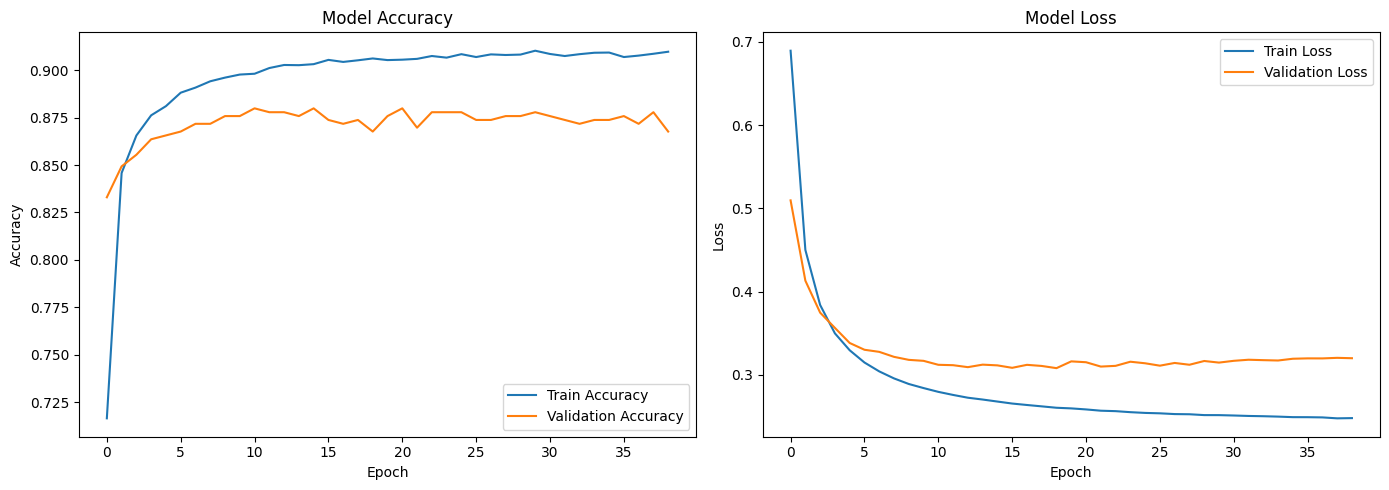

In [61]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from your model's fit method
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()
plt.show()


In [62]:
# Evaluate on training data
train_loss, train_accuracy = gnn_model.evaluate(x_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

# Evaluate on validation data (if you have separate validation data)
val_loss, val_accuracy = gnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Training Loss: 0.2585, Training Accuracy: 0.9073
Validation Loss: 0.3303, Validation Accuracy: 0.8692


In [63]:
print(f"x_train shape: {x_test.shape}")
print(f"y_train shape: {y_test.shape}")

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")


x_train shape: (9907, 500)
y_train shape: (9907, 3)
x_train shape: (9810, 500)
y_train shape: (9810, 3)


In [64]:
# Print final training and validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]  # Last validation accuracy

print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

Final Validation Accuracy: 0.8676


In [65]:
# Print final training and validation accuracy
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]  # Last validation accuracy

print(f'Final Training Accuracy: {final_accuracy:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

Final Training Accuracy: 0.9096
Final Validation Accuracy: 0.8676


Let's plot the learning curves

Now we evaluate the GNN model on the test data split.
The results may vary depending on the training sample, however the GNN model always outperforms
the baseline model in terms of the test accuracy.

### Examine the GNN model predictions

Let's add the new instances as nodes to the `node_features`, and generate links
(citations) to existing nodes.

Now let's update the `node_features` and the `edges` in the GNN model.

Notice that the probabilities of the expected subjects
(to which several citations are added) are higher compared to the baseline model.

In [66]:
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, mean_absolute_error, roc_auc_score
# import numpy as np

# class GNNEvaluationMetrics:
#     def __init__(self, history):
#         self.history = history
#         self.y_true = None
#         self.y_pred = None

#     def set_true_pred(self, y_true, y_pred):
#         self.y_true = y_true
#         self.y_pred = y_pred

#     def accuracy(self):
#         return accuracy_score(self.y_true, self.y_pred) if self.y_true is not None and self.y_pred is not None else None
    
#     def precision(self):
#         return precision_score(self.y_true, self.y_pred, average='weighted') if self.y_true is not None and self.y_pred is not None else None
    
#     def recall(self):
#         return recall_score(self.y_true, self.y_pred, average='weighted') if self.y_true is not None and self.y_pred is not None else None
    
#     def f1(self):
#         return f1_score(self.y_true, self.y_pred, average='weighted') if self.y_true is not None and self.y_pred is not None else None
    
#     def rmse(self):
#         return np.sqrt(mean_squared_error(self.y_true, self.y_pred)) if self.y_true is not None and self.y_pred is not None else None
    
#     def mae(self):
#         return mean_absolute_error(self.y_true, self.y_pred) if self.y_true is not None and self.y_pred is not None else None

#     def auc(self):
#         return roc_auc_score(self.y_true, self.y_pred) if len(set(self.y_true)) == 2 and self.y_true is not None and self.y_pred is not None else None

#     def ndcg(self, k=10):
#         def dcg_at_k(r, k):
#             r = np.asfarray(r)[:k]
#             return np.sum(r / np.log2(np.arange(2, r.size + 2)))

#         def ndcg_at_k(r, k):
#             dcg_max = dcg_at_k(sorted(r, reverse=True), k)
#             if not dcg_max:
#                 return 0.
#             return dcg_at_k(r, k) / dcg_max

#         if self.y_true is None or self.y_pred is None:
#             return None

#         scores = np.array(self.y_pred)
#         labels = np.array(self.y_true)
        
#         ranking = np.argsort(scores)[::-1]
#         ranked_labels = labels[ranking]
        
#         return ndcg_at_k(ranked_labels, k)

#     def training_metrics(self):
#         return self.history.history  # Return history of training metrics (loss, accuracy, etc.)

In [67]:
y_pred = gnn_model.predict(x_test)


310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [68]:

def convert_continuous_to_discrete(y_pred):
    # Create a binary array with the same shape as y_pred
    y_pred_classes = np.zeros(y_pred.shape, dtype=int)
    # Get the index of the maximum value for each row
    max_indices = np.argmax(y_pred, axis=1)
    # Set the corresponding class index to 1
    y_pred_classes[np.arange(y_pred.shape[0]), max_indices] = 1
    return y_pred_classes

# Apply the function to your y_pred
y_pred_classes = convert_continuous_to_discrete(y_pred)

In [69]:
import numpy as np

# Assuming y_pred contains probabilities for each class
# Convert continuous predictions to discrete class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# If y_true is one-hot encoded, convert it to class indices
y_true_classes = np.argmax(y_test, axis=1)

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8691834056727566
Precision: 0.8698412633640924
Recall: 0.8691834056727566
F1 Score: 0.8689492340817505


In [71]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Instance 1:
- 1: 23.49%
- 2: 45.63%
- 3: 30.88%
Instance 2:
- 1: 34.08%
- 2: 41.16%
- 3: 24.76%
Instance 3:
- 1: 9.42%
- 2: 54.99%
- 3: 35.58%


In [72]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features_temp.shape[0]
new_node_features = np.concatenate([node_features_temp, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [73]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 44338)
Nodes shape: (19717, 500)


In [74]:
history

In [75]:
# Assuming 'history' is your History object
history_dict = history.history

# Extracting metrics
train_loss = history_dict['loss']
train_accuracy = history_dict.get('accuracy') or history_dict.get('acc')  # Depending on Keras version
val_loss = history_dict.get('val_loss')
val_accuracy = history_dict.get('val_accuracy') or history_dict.get('val_acc')

In [76]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# # Assuming 'history' is your History object
# history_dict = history.history

# # Extract training history
# train_loss = history_dict['loss']
# train_accuracy = history_dict.get('accuracy', history_dict.get('acc'))
# val_loss = history_dict.get('val_loss', [])
# val_accuracy = history_dict.get('val_accuracy', history_dict.get('val_acc', []))

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_accuracy, label='Train')
# if val_accuracy:
#     plt.plot(val_accuracy, label='Validation')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(train_loss, label='Train')
# if val_loss:
#     plt.plot(val_loss, label='Validation')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Print final training (and validation) metrics
# print(f"Final training accuracy: {train_accuracy[-1]:.4f}")
# print(f"Final training loss: {train_loss[-1]:.4f}")
# if val_accuracy:
#     print(f"Final validation accuracy: {val_accuracy[-1]:.4f}")
# if val_loss:
#     print(f"Final validation loss: {val_loss[-1]:.4f}")

# # Generate predictions on test set (assuming you have x_test and y_test)
# y_pred = gnn_model.predict(x_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true_classes = np.argmax(y_test, axis=1)

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# # Class 0: Diabetes Type 1
# # Class 1: Diabetes Type 2
# # Class 2: Experimental research on diabetes (other diabetes-related studies)
# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental'],
#             yticklabels=['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(y_true_classes, y_pred_classes))

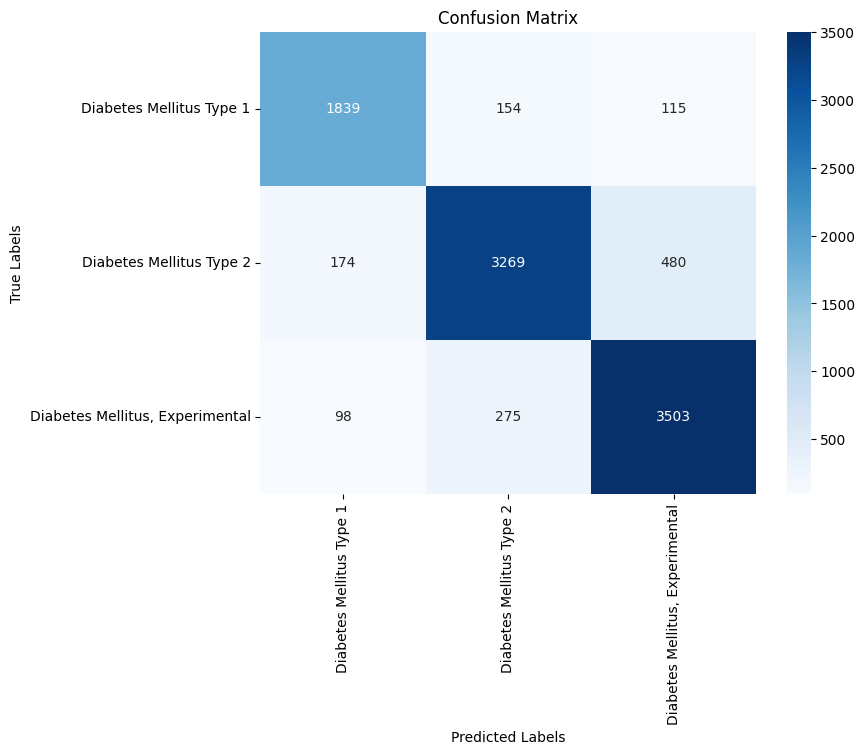


Classification Report:
                                 precision    recall  f1-score   support

       Diabetes Mellitus Type 1       0.87      0.87      0.87      2108
       Diabetes Mellitus Type 2       0.88      0.83      0.86      3923
Diabetes Mellitus, Experimental       0.85      0.90      0.88      3876

                       accuracy                           0.87      9907
                      macro avg       0.87      0.87      0.87      9907
                   weighted avg       0.87      0.87      0.87      9907



In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define descriptive class names
class_names = ["Diabetes Mellitus Type 1", "Diabetes Mellitus Type 2", "Diabetes Mellitus, Experimental"]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report with descriptive labels
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


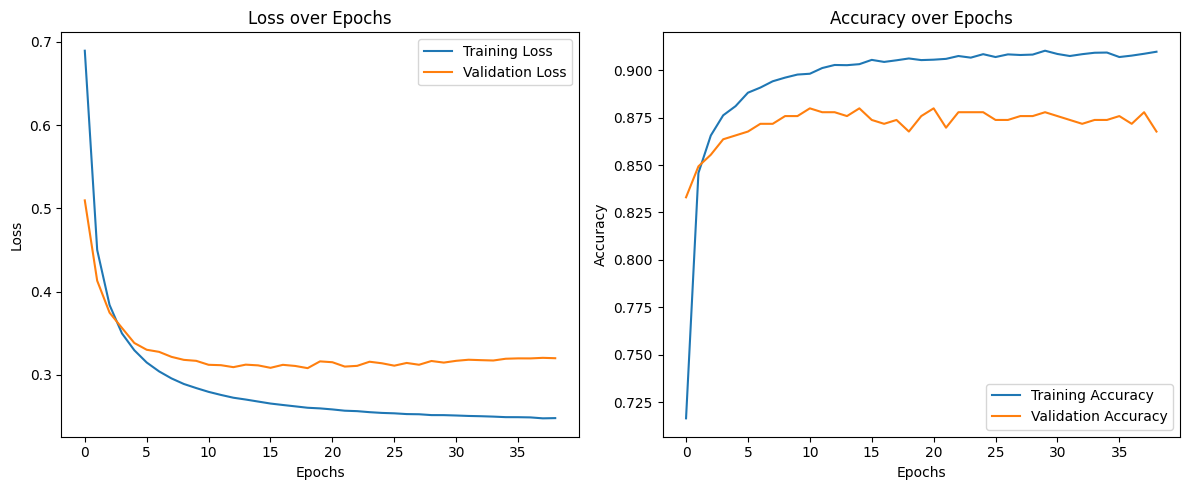

In [78]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
if val_accuracy is not None:
    plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

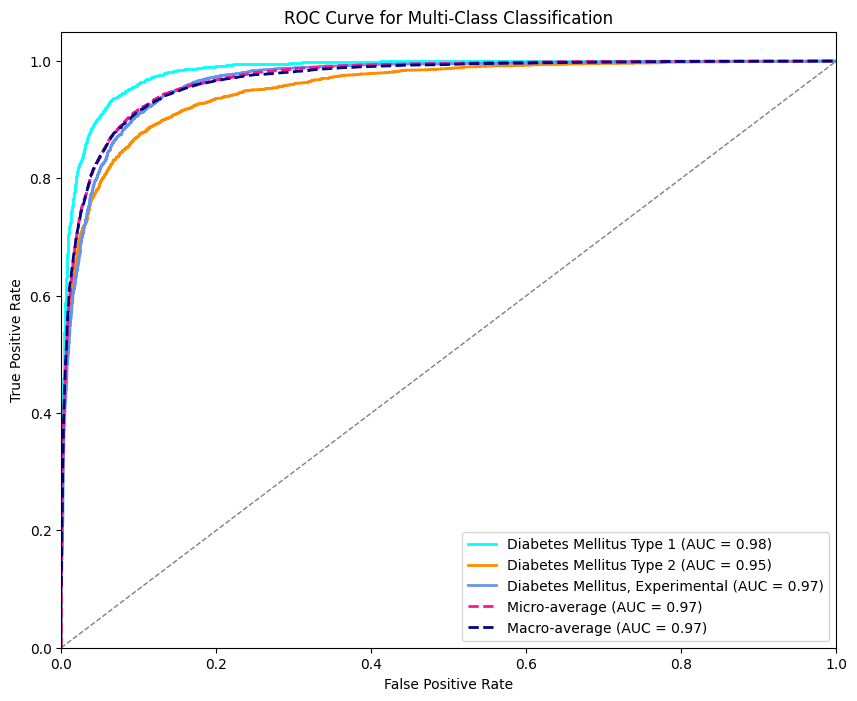

In [79]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Assuming y_test is one-hot encoded and y_pred contains predicted probabilities
num_classes = y_test.shape[1]  # Number of classes

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Define descriptive class names
class_names = ['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental']

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='deeppink', lw=2,
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='navy', lw=2,
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()


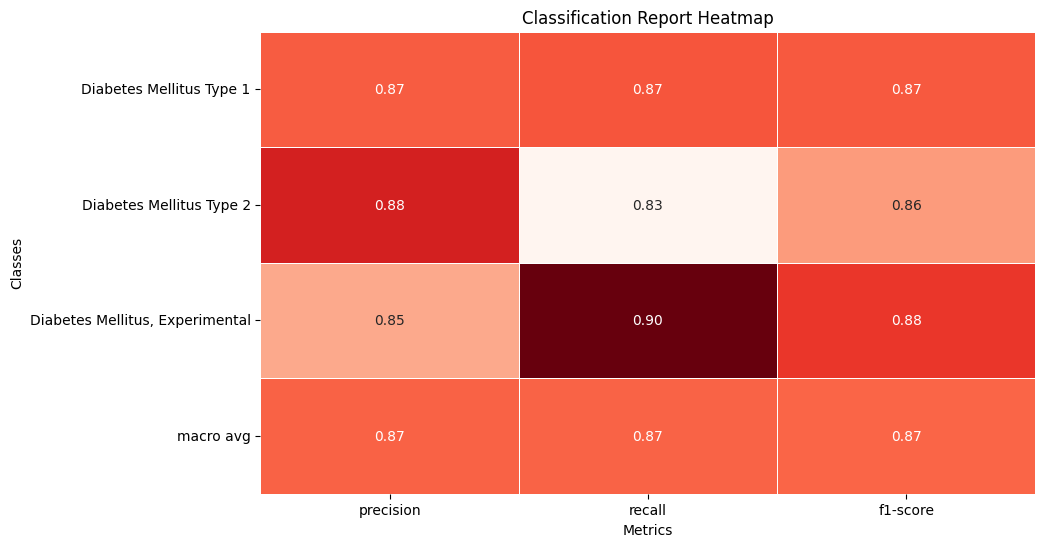

In [80]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_true_classes and y_pred_classes are your true and predicted labels
# Generate classification report as a dictionary
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Convert the dictionary into a Pandas DataFrame for visualization
report_df = pd.DataFrame(report_dict).transpose()

# Map numeric indices to descriptive class names
class_names = ['Diabetes Mellitus Type 1', 'Diabetes Mellitus Type 2', 'Diabetes Mellitus, Experimental']
report_df.index = [class_names[int(i)] if i.isdigit() else i for i in report_df.index]

# Extract only relevant columns for better readability
if "accuracy" in report_df.index:  # accuracy row is not relevant for heatmap
    report_df = report_df.drop("accuracy", axis=0)

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Reds", fmt=".2f", cbar=False, linewidths=0.5)

# Add labels and title
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()
